In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import os
import logging
import datetime
import warnings
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn import metrics
%matplotlib inline

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))


#from google.colab import drive
#drive.mount('/content/gdrive', force_remount=True)


#print(os.listdir("gdrive/My Drive/Colab Notebooks/DSA - Vendas Store/."))

# Any results you write to the current directory are saved as output.

/Users/cleversoncachoeira/anaconda/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
IS_LOCAL = True
if(IS_LOCAL):
    PATH="gdrive/My Drive/Colab Notebooks/DSA - Vendas Store/"
else:
    PATH="../input/"
os.listdir(PATH)

FileNotFoundError: [Errno 2] No such file or directory: 'gdrive/My Drive/Colab Notebooks/DSA - Vendas Store/'

In [4]:
PATH="./"

In [15]:
label_df = pd.read_csv(PATH+"dengue_labels_train.csv")

In [16]:
label_df.head()

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6


In [17]:
label_df.describe()

,year,weekofyear,total_cases
count,1456.000000,1456.000000,1456.000000
mean,2001.031593,26.503434,24.675137
std,5.408314,15.019437,43.596000
min,1990.000000,1.000000,0.000000
25%,1997.000000,13.750000,5.000000
50%,2002.000000,26.500000,12.000000
75%,2005.000000,39.250000,28.000000
max,2010.000000,53.000000,461.000000


In [18]:
def missing_data(data):
    total = data.isnull().sum()
    percent = (data.isnull().sum()/data.isnull().count()*100)
    tt = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    types = []
    for col in data.columns:
        dtype = str(data[col].dtype)
        types.append(dtype)
    tt['Types'] = types
    return(np.transpose(tt))

In [19]:
%%time
missing_data(label_df) 

CPU times: user 5.14 ms, sys: 782 µs, total: 5.92 ms
Wall time: 5.24 ms


,city,year,weekofyear,total_cases
Total,0,0,0,0
Percent,0,0,0,0
Types,object,int64,int64,int64


In [20]:
train_df = pd.read_csv(PATH+"dengue_features_train.csv")

In [21]:
train_df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8


In [22]:
train_df.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [23]:
missing_data(train_df)

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
Total,0,0,0,0,194,52,22,22,13,10,...,10,10,13,10,10,43,43,20,14,22
Percent,0,0,0,0,13.3242,3.57143,1.51099,1.51099,0.892857,0.686813,...,0.686813,0.686813,0.892857,0.686813,0.686813,2.9533,2.9533,1.37363,0.961538,1.51099
Types,object,int64,int64,object,float64,float64,float64,float64,float64,float64,...,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [24]:
test_df = pd.read_csv(PATH+"dengue_features_test.csv")

In [25]:
test_df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,2008,18,2008-04-29,-0.0189,-0.018900,0.102729,0.091200,78.60,298.492857,...,25.37,78.781429,78.60,15.918571,3.128571,26.528571,7.057143,33.3,21.7,75.2
1,sj,2008,19,2008-05-06,-0.0180,-0.012400,0.082043,0.072314,12.56,298.475714,...,21.83,78.230000,12.56,15.791429,2.571429,26.071429,5.557143,30.0,22.2,34.3
2,sj,2008,20,2008-05-13,-0.0015,NaN,0.151083,0.091529,3.66,299.455714,...,4.12,78.270000,3.66,16.674286,4.428571,27.928571,7.785714,32.8,22.8,3.0
3,sj,2008,21,2008-05-20,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,...,2.20,73.015714,0.00,15.775714,4.342857,28.057143,6.271429,33.3,24.4,0.3
4,sj,2008,22,2008-05-27,0.0568,0.039833,0.062267,0.075914,0.76,299.780000,...,4.36,74.084286,0.76,16.137143,3.542857,27.614286,7.085714,33.3,23.3,84.1


In [26]:
test_df.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,416.000000,416.000000,373.000000,405.000000,415.000000,415.000000,414.000000,414.000000,414.000000,414.000000,...,414.000000,414.000000,414.000000,414.000000,414.000000,404.000000,404.000000,413.000000,407.000000,411.000000
mean,2010.766827,26.439904,0.126050,0.126803,0.207702,0.201721,38.354324,298.818295,299.353071,295.419179,...,42.171135,82.499810,38.354324,16.927088,5.124569,27.369587,7.810991,32.534625,22.368550,34.278589
std,1.434835,14.978257,0.164353,0.141420,0.079102,0.092028,35.171126,1.469501,1.306233,1.523099,...,48.909514,7.378243,35.171126,1.557868,3.542870,1.232608,2.449718,1.920429,1.731437,34.655966
min,2008.000000,1.000000,-0.463400,-0.211800,0.006200,-0.014671,0.000000,294.554286,295.235714,290.818571,...,0.000000,64.920000,0.000000,12.537143,1.485714,24.157143,4.042857,27.200000,14.200000,0.000000
25%,2010.000000,13.750000,-0.001500,0.015975,0.148670,0.134079,8.175000,297.751429,298.323214,294.335714,...,9.430000,77.397143,8.175000,15.792857,2.446429,26.514286,5.928571,31.100000,21.200000,9.100000
50%,2011.000000,26.000000,0.110100,0.088700,0.204171,0.186471,31.455000,298.547143,299.328571,295.825000,...,25.850000,80.330000,31.455000,17.337143,2.914286,27.483333,6.642857,32.800000,22.200000,23.600000
75%,2012.000000,39.000000,0.263329,0.242400,0.254871,0.253243,57.772500,300.240357,300.521429,296.643571,...,56.475000,88.328929,57.772500,18.174643,8.171429,28.319048,9.812500,33.900000,23.300000,47.750000
max,2013.000000,53.000000,0.500400,0.649000,0.453043,0.529043,169.340000,301.935714,303.328571,297.794286,...,301.400000,97.982857,169.340000,19.598571,14.485714,30.271429,14.725000,38.400000,26.700000,212.000000


In [27]:
test_df.columns

Index(['city', 'year', 'weekofyear', 'week_start_date', 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm'],
      dtype='object')

In [28]:
submit = pd.read_csv(PATH+"submission_format.csv")

In [29]:
submit.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,0
1,sj,2008,19,0
2,sj,2008,20,0
3,sj,2008,21,0
4,sj,2008,22,0


In [30]:
label_df.shape, train_df.shape, test_df.shape

((1456, 4), (1456, 24), (416, 24))

In [31]:
train_df.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
count,1456.000000,1456.000000,1262.000000,1404.000000,1434.000000,1434.000000,1443.000000,1446.000000,1446.000000,1446.000000,...,1446.000000,1446.000000,1443.000000,1446.000000,1446.000000,1413.000000,1413.000000,1436.000000,1442.000000,1434.000000
mean,2001.031593,26.503434,0.142294,0.130553,0.203783,0.202305,45.760388,298.701852,299.225578,295.246356,...,40.151819,82.161959,45.760388,16.746427,4.903754,27.185783,8.059328,32.452437,22.102150,39.326360
std,5.408314,15.019437,0.140531,0.119999,0.073860,0.083903,43.715537,1.362420,1.261715,1.527810,...,43.434399,7.153897,43.715537,1.542494,3.546445,1.292347,2.128568,1.959318,1.574066,47.455314
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,294.635714,294.892857,289.642857,...,0.000000,57.787143,0.000000,11.715714,1.357143,21.400000,4.528571,26.700000,14.700000,0.000000
25%,1997.000000,13.750000,0.044950,0.049217,0.155087,0.144209,9.800000,297.658929,298.257143,294.118929,...,13.055000,77.177143,9.800000,15.557143,2.328571,26.300000,6.514286,31.100000,21.100000,8.700000
50%,2002.000000,26.500000,0.128817,0.121429,0.196050,0.189450,38.340000,298.646429,299.289286,295.640714,...,27.245000,80.301429,38.340000,17.087143,2.857143,27.414286,7.300000,32.800000,22.200000,23.850000
75%,2005.000000,39.250000,0.248483,0.216600,0.248846,0.246982,70.235000,299.833571,300.207143,296.460000,...,52.200000,86.357857,70.235000,17.978214,7.625000,28.157143,9.566667,33.900000,23.300000,53.900000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,390.600000,302.200000,302.928571,298.450000,...,570.500000,98.610000,390.600000,20.461429,16.028571,30.800000,15.800000,42.200000,25.600000,543.300000


In [38]:
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

In [39]:
features = [ 'ndvi_ne', 'ndvi_nw',
       'ndvi_se', 'ndvi_sw', 'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', ]

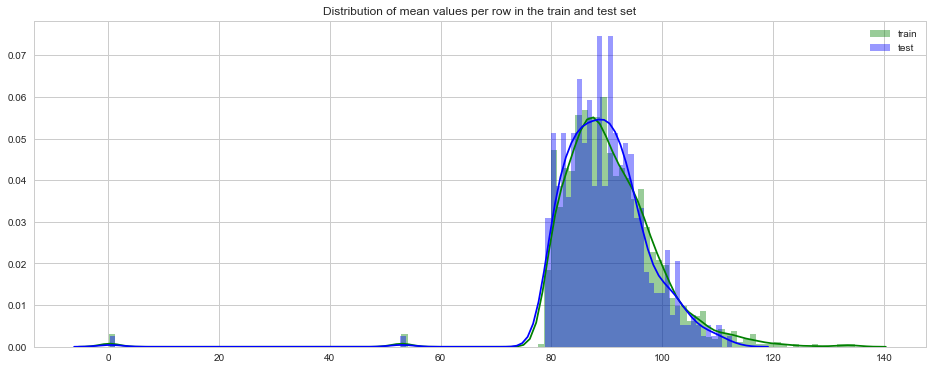

In [43]:
plt.figure(figsize=(16,6))
features = train_df.columns.values[2:24]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

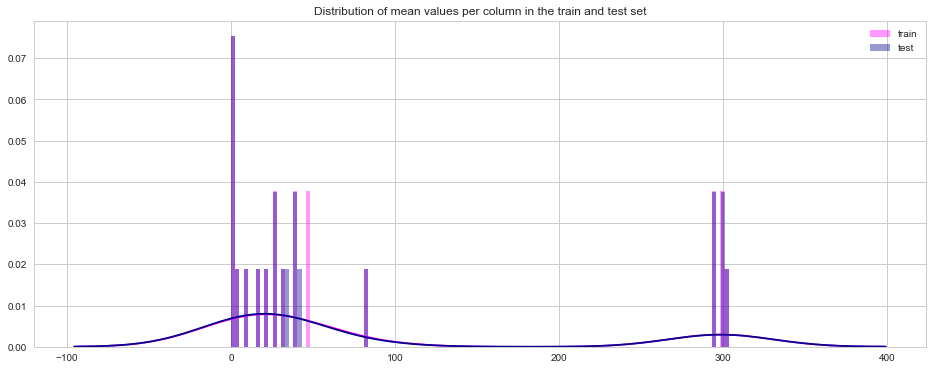

In [44]:
plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

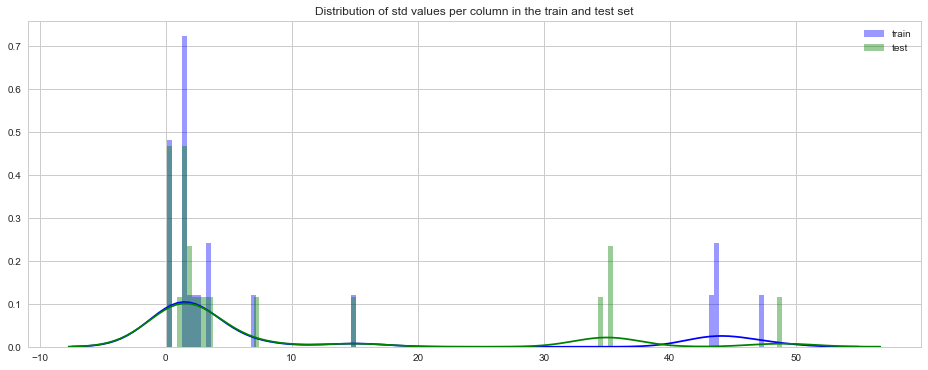

In [46]:
plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train_df[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

In [48]:
%%time
correlations = train_df[features].corr().abs().unstack().sort_values(kind="quicksort").reset_index()
correlations = correlations[correlations['level_0'] != correlations['level_1']]
correlations.head(10)

CPU times: user 8.13 ms, sys: 1.64 ms, total: 9.77 ms
Wall time: 8.4 ms


In [49]:
correlations.tail(10)

,level_0,level_1,0
410,station_diur_temp_rng_c,reanalysis_tdtr_k,0.881176
411,reanalysis_tdtr_k,station_diur_temp_rng_c,0.881176
412,reanalysis_avg_temp_k,reanalysis_air_temp_k,0.901777
413,reanalysis_air_temp_k,reanalysis_avg_temp_k,0.901777
414,reanalysis_max_air_temp_k,reanalysis_tdtr_k,0.918578
415,reanalysis_tdtr_k,reanalysis_max_air_temp_k,0.918578
416,reanalysis_dew_point_temp_k,reanalysis_specific_humidity_g_per_kg,0.997051
417,reanalysis_specific_humidity_g_per_kg,reanalysis_dew_point_temp_k,0.997051
426,precipitation_amt_mm,reanalysis_sat_precip_amt_mm,1.000000
433,reanalysis_sat_precip_amt_mm,precipitation_amt_mm,1.000000


In [50]:
correlations.head(10)

,level_0,level_1,0
0,reanalysis_max_air_temp_k,reanalysis_air_temp_k,0.001211
1,reanalysis_air_temp_k,reanalysis_max_air_temp_k,0.001211
2,ndvi_se,reanalysis_dew_point_temp_k,0.002810
3,reanalysis_dew_point_temp_k,ndvi_se,0.002810
4,reanalysis_tdtr_k,reanalysis_specific_humidity_g_per_kg,0.012948
5,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,0.012948
6,reanalysis_relative_humidity_percent,weekofyear,0.015191
7,weekofyear,reanalysis_relative_humidity_percent,0.015191
8,precipitation_amt_mm,reanalysis_air_temp_k,0.017229
9,reanalysis_sat_precip_amt_mm,reanalysis_air_temp_k,0.017229
